In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
import pickle as pkl
from tqdm import tqdm
import pandas as pd

sys.path.append('..')
from sim_biology import p, load_dataloader_and_pretrained_model, dataloader_to_nparrays
# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform1d import DWT1d
from utils import get_1dfilts, get_wavefun
from wave_attributions import Attributer
from visualize import cshow, plot_1dreconstruct, plot_1dfilts, plot_wavefun

# load results

In [2]:
dirs = ["db5_saliency_warmstart_lamL1wave=0.1_seed=100"]
results = []
models = []
for i in range(len(dirs)):
    # load results
    out_dir = opj("/home/ubuntu/adaptive-wavelets/notebooks/ex_biology/results", dirs[i])
    fnames = sorted(os.listdir(out_dir))
    
    results_list = []
    models_list = []
    for fname in fnames:
        if fname[-3:] == 'pkl':
            results_list.append(pkl.load(open(opj(out_dir, fname), 'rb')))
        if fname[-3:] == 'pth':
            wt = DWT1d(wave='db5', mode='zero', J=4, init_factor=1, noise_factor=0.1).to(device)
            wt.load_state_dict(torch.load(opj(out_dir, fname)))
            models_list.append(wt)
    results.append(pd.DataFrame(results_list))
    models.append(models_list)

## load data and model

In [3]:
# get dataloader and model
(train_loader, test_loader), model = load_dataloader_and_pretrained_model(p)
torch.manual_seed(p.seed)
data = iter(test_loader).next()[0].to(device)

# Plotting

Hyperparameter: lamL1wave=0.100000 lamL1attr=0.625060
Error: Recon=0.001013


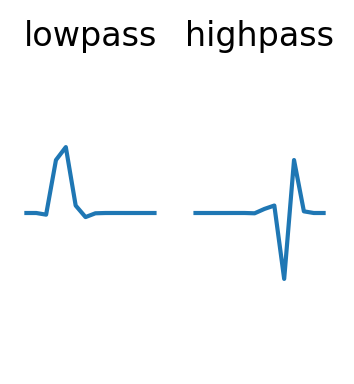

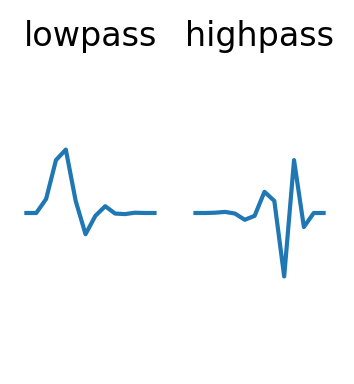

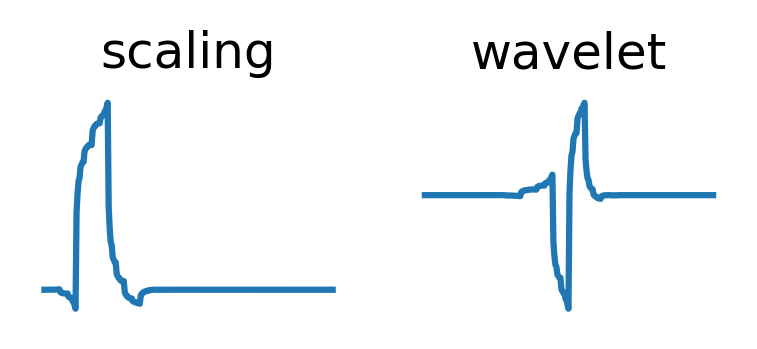

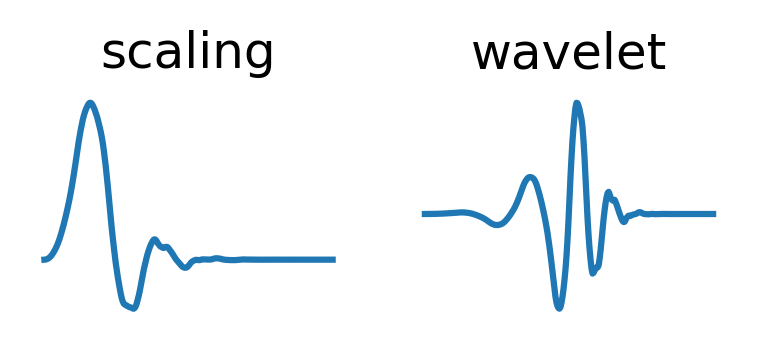

In [60]:
res = results[0]
mos = models[0]
lamL1attrs = np.array(res['lamL1attr'])
index = {}
for i in range(50):
    index[i] = np.argsort(lamL1attrs)[i]
rec_loss = np.array(res['rec_loss'])[np.argsort(lamL1attrs)]
L1saliency_loss = np.array(res['L1saliency_loss'])[np.argsort(lamL1attrs)]
L1inputxgrad_loss = np.array(res['L1inputxgrad_loss'])[np.argsort(lamL1attrs)]    

ix = 22
wt = mos[index[ix]]
filt = get_1dfilts(wt)
phi, psi, x = get_wavefun(wt)
print('Hyperparameter: lamL1wave={:.6f} lamL1attr={:.6f}'.format(res['lamL1wave'][index[ix]], res['lamL1attr'][index[ix]]))
print('Error: Recon={:.6f}'.format(res['rec_loss'][index[ix]]))

# original wavelet
wt_o = DWT1d(wave=res['wave'][0], mode='zero', J=res['J'][0], init_factor=1, noise_factor=0).to(device)
filt_o = get_1dfilts(wt_o)
phi_o, psi_o, x_o = get_wavefun(wt_o)

plot_1dfilts(filt, is_title=True, figsize=(2,2))
plot_1dfilts(filt_o, is_title=True, figsize=(2,2))

plot_wavefun((phi, psi, x), is_title=True, figsize=(3,1))
plot_wavefun((phi_o, psi_o, x_o), is_title=True, figsize=(3,1))

In [61]:
def dataloader_to_nparrays(w_transform, train_loader, test_loader):
    w_transform = w_transform.to('cpu')
    J = w_transform.J
    X = []
    y = []
    for data, labels in train_loader:
        data_t = w_transform(data)
        for j in range(J+1):
            if j == 0:
                x = deepcopy(torch.max(data_t[j].detach(), dim=2)[0])
            else:
                x = torch.cat((x, torch.max(data_t[j].detach(), dim=2)[0]), axis=1)    
        X.append(x)
        y.append(labels)
    X = torch.cat(X).squeeze().numpy()
    y = torch.cat(y).squeeze().numpy()

    X_test = []
    y_test = []
    for data, labels in test_loader:
        data_t = w_transform(data)
        for j in range(J+1):
            if j == 0:
                x = deepcopy(torch.max(data_t[j].detach(), dim=2)[0])
            else:
                x = torch.cat((x, torch.max(data_t[j].detach(), dim=2)[0]), axis=1)              
        X_test.append(x)
        y_test.append(labels)
    X_test = torch.cat(X_test).squeeze().numpy()
    y_test = torch.cat(y_test).squeeze().numpy()   
    
    return (X, y), (X_test, y_test)

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

wt = wt.to('cpu')

(X, y), (X_test, y_test) = dataloader_to_nparrays(wt, train_loader, test_loader)
clf = LogisticRegression().fit(X, y)
preds = clf.predict(X_test)
error = abs(preds - y_test).sum()/X_test.shape[0]
print(error)

wt_o = wt_o.to('cpu')

(X, y), (X_test, y_test) = dataloader_to_nparrays(wt_o, train_loader, test_loader)
clf = LogisticRegression().fit(X, y)
preds = clf.predict(X_test)
error = abs(preds - y_test).sum()/X_test.shape[0]
print(error)

0.2975124378109453
0.31044776119402984
